In [1]:
# Install and load necessary libraries for visualization
if (!requireNamespace("pheatmap", quietly = TRUE)) {
  install.packages("pheatmap")
}
if (!requireNamespace("outliers", quietly = TRUE)) {
  install.packages("outliers")
}
# Install and load the 'entropy' package if not already installed
if (!requireNamespace("entropy", quietly = TRUE)) {
  install.packages("entropy")
}
if (!requireNamespace("anomalize", quietly = TRUE)) {
  install.packages("anomalize")
}
if (!requireNamespace("tidyverse", quietly = TRUE)) {
  install.packages("tidyverse")
}
if (!requireNamespace("dbscan", quietly = TRUE)) {
  install.packages("dbscan")
}
if (!requireNamespace("dbscan", quietly = TRUE)) {
  install.packages("dbscan")
}
if (!requireNamespace("changepoint", quietly = TRUE)) {
  install.packages("tsibble")
}

library(dbscan)
library(tidyverse)
library(tibbletime)
library(anomalize)
library(timetk)
library(entropy)
library(pheatmap)
library(ggplot2)
library(gridExtra)
library(tsoutliers)
library(keras)
library(reticulate)


Attaching package: ‘dbscan’


The following object is masked from ‘package:stats’:

    as.dendrogram


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘tibbletime’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘timetk’


The following objects are masked from ‘package:anomalize’:

    anomalize, plot_anomalies



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Registered S3 method overwritten by 'quantmo

In [2]:
# Load the dataset
# Spécifier le nombre de lignes à charger (40%)
#n_lines_to_load <- round(0.005 * length(readLines("ar41_for_ulb.csv")))

# Charger 40% des lignes du fichier CSV
data <- read.csv("ar41_for_ulb.csv", nrows = 300000)
#data <- read.csv("ar41_for_ulb_mini.csv")

In [3]:
# Data Type Conversion
data_split <- strsplit(as.character(data$X.mapped_veh_id.timestamps_UTC.lat.lon.RS_E_InAirTemp_PC1.RS_E_InAirTemp_PC2.RS_E_OilPress_PC1.RS_E_OilPress_PC2.RS_E_RPM_PC1.RS_E_RPM_PC2.RS_E_WatTemp_PC1.RS_E_WatTemp_PC2.RS_T_OilTemp_PC1.RS_T_OilTemp_PC2), ";")
data_df <- as.data.frame(do.call(rbind, data_split))
colnames(data_df) <- c("X","mapped_veh_id", "timestamps_UTC", "lat", "lon", "RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")
data_df <- subset(data_df, select = -X)
# Convert mapped_veh_id to integer

data_df$mapped_veh_id <- as.factor(data_df$mapped_veh_id)
data_df$timestamps_UTC <- as.POSIXct(data_df$timestamps_UTC, format = "%Y-%m-%d %H:%M:%S")
columns_to_convert <- c("lat", "lon","RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")
for (col in columns_to_convert) {
  data_df[, col] <- as.numeric(gsub(",", ".", data_df[, col]))
}


Warning message in (function (..., deparse.level = 1) :
“number of columns of result is not a multiple of vector length (arg 1591)”


In [4]:
# Check for NA values
na_count <- sum(is.na(data_df))
if (na_count > 0) {
  print(paste("There are", na_count, "NA values in the dataset. Handle them appropriately."))
}
# Remove duplicate rows
data_df <- data_df[!duplicated(data_df), ]

[1] "There are 756 NA values in the dataset. Handle them appropriately."


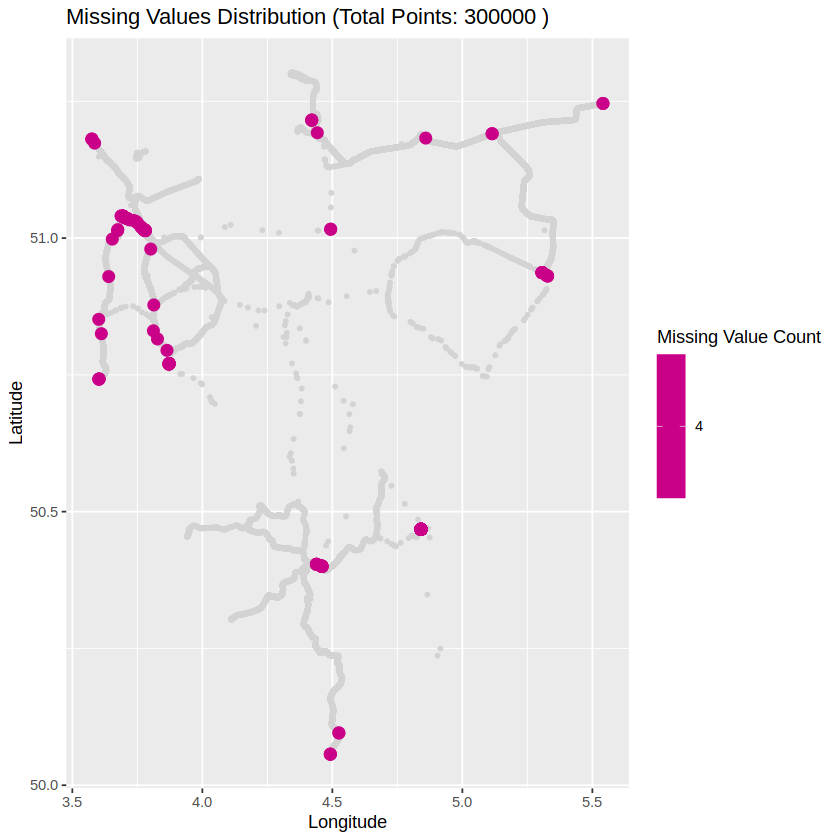

In [5]:
# Check for NA values in any of the specified columns
missing_values <- rowSums(is.na(data_df[, c("RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")]))

# Check if there are any missing values
if (sum(missing_values) > 0) {
  # Create a new data frame for missing values
  missing_data <- data.frame(lon = data_df$lon[missing_values > 0],
                              lat = data_df$lat[missing_values > 0],
                              missing_count = missing_values[missing_values > 0])

  # Create a plot with missing values
  ggplot(data_df, aes(x = lon, y = lat)) +
    geom_point(size = 1, color = "lightgray") +
    geom_point(data = missing_data, aes(color = missing_count), size = 3) +
    scale_color_gradient(low = "blue", high = "red") +
    labs(title = paste("Missing Values Distribution (Total Points:", nrow(data_df), ")"),
        x = "Longitude",
        y = "Latitude",
        color = "Missing Value Count")

} else {
  # Create a plot without missing values
  library(ggplot2)
  ggplot(data_df, aes(x = lon, y = lat)) +
    geom_point(size = 1, color = "lightgray") +
    labs(title = paste("Total Points:", nrow(data_df)),
        x = "Longitude",
        y = "Latitude")+
    theme_minimal()
}


In [6]:
missing_analysis <- data.frame(feature = colnames(data_df)[7:16], 
                                 missing_count = colSums(is.na(data_df[, c("RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")])))
# Filter features with missing values
missing_analysis_filtered <- missing_analysis[missing_analysis$missing_count > 0, ]

# Print the filtered analysis
if (nrow(missing_analysis_filtered) > 0) {
  print("Analysis of Features with Missing Values:")
  print(missing_analysis_filtered)
} else {
  print("Aucune feature n'a de valeur manquante.")
}


[1] "Analysis of Features with Missing Values:"
                             feature missing_count
RS_E_InAirTemp_PC2 RS_E_OilPress_PC2           189
RS_E_OilPress_PC2       RS_E_RPM_PC2           189
RS_E_RPM_PC2        RS_E_WatTemp_PC2           189
RS_E_WatTemp_PC2    RS_T_OilTemp_PC2           189


In [7]:
# Sélectionner les colonnes pertinentes pour l'imputation
cols_capteur_1 <- c("RS_E_InAirTemp_PC1", "RS_E_OilPress_PC1", "RS_E_RPM_PC1", "RS_E_WatTemp_PC1", "RS_T_OilTemp_PC1")
cols_capteur_2 <- c("RS_E_InAirTemp_PC2", "RS_E_OilPress_PC2", "RS_E_RPM_PC2", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC2")

# Créer un dataframe pour l'imputation
impute_data <- data_df[, c(cols_capteur_1, cols_capteur_2)]

# Imputation des valeurs manquantes des capteurs 2 en utilisant les capteurs 1
for (col in cols_capteur_2) {
  impute_data[[col]][is.na(impute_data[[col]])] <- impute_data[[sub("_PC2", "_PC1", col)]][is.na(impute_data[[col]])]
}

# Créer une copie de data_df avec les valeurs manquantes imputées
data_df_impute <- data_df
data_df_impute[, cols_capteur_2] <- impute_data[, cols_capteur_2]

In [8]:
# Assuming data_df_WNA is your dataframe without NA values

# Detect and handle outliers using the IQR method
handle_outliers <- function(column) {
  Q1 <- quantile(column, 0.10)
  Q3 <- quantile(column, 0.90)
  IQR_value <- Q3 - Q1
  lower_limit <- Q1 - 1.5 * IQR_value
  upper_limit <- Q3 + 1.5 * IQR_value
  column[column < lower_limit] <- lower_limit
  column[column > upper_limit] <- upper_limit
  return(column)
}

# Apply outlier handling to relevant numeric columns
columns_to_handle_outliers <- c("lat", "lon", "RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")

for (col in columns_to_handle_outliers) {
  data_df_impute[, col] <- handle_outliers(data_df_impute[, col])
}

In [9]:
# Subset the data for selected variables
#selected_vars <- c("RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1","RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")

# Subset the data
#subset_data <- data_df_impute[c("timestamps_UTC", selected_vars)]

# Melt the data for easier plotting
#melted_data <- reshape2::melt(subset_data, id.vars = "timestamps_UTC")

# Normalize the data
#melted_data$value <- scale(melted_data$value)

# Create a separate plot for each variable
#plots_list <- lapply(selected_vars, function(var) {
#  ggplot(melted_data[melted_data$variable == var, ], aes(x = timestamps_UTC, y = value)) +
#    geom_line() +
#    labs(title = paste(var),
#         x = "Timestamps",
#         y = "Variable Values") +
#    theme_minimal()
#})

#grid.arrange(grobs = plots_list)  # Adjust ncol as needed


In [10]:
# Check for NA values
na_count <- sum(is.na(data_df))

if (na_count > 0) {
  print(paste("There are", na_count, "NA values in the dataset. Removing them."))

  # Remove rows with NA values
  data_df_WNA <- na.omit(data_df)
}else {

  # Now, your data doesn't contain NA values, and you can proceed with further analysis or visualization.
  data_df_WNA <- data_df
}



[1] "There are 756 NA values in the dataset. Removing them."


In [11]:
columns_to_handle_outliers <- c("lat", "lon", "RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")
for (col in columns_to_handle_outliers) {
  data_df_WNA[, col] <- handle_outliers(data_df_WNA[, col])
}


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




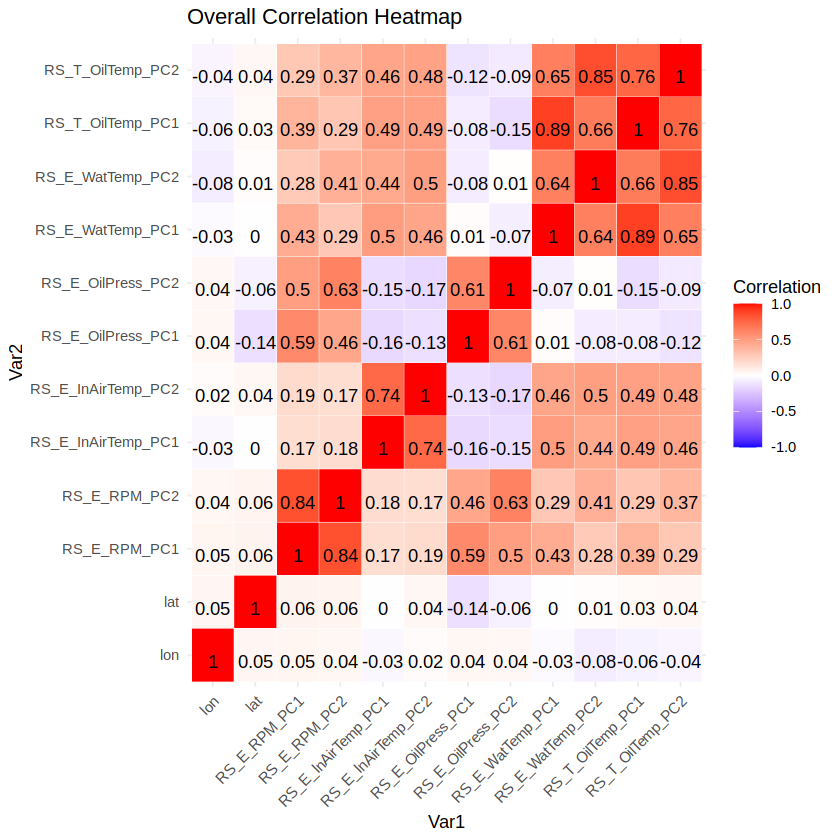

In [12]:
# Assuming data_df_WNA is your dataset with appropriate column names

# Select relevant columns for correlation analysis (excluding non-numeric and "Group" columns)
cor_columns <- c("lon","lat","RS_E_RPM_PC1","RS_E_RPM_PC2","RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")

# Select only numeric columns for correlation analysis
numeric_data <- data_df_WNA[, sapply(data_df_WNA, is.numeric)]

# Calculate the correlation matrix
cor_matrix <- cor(numeric_data[, cor_columns])

# Plot a heatmap for the overall correlation matrix
library(ggplot2)
library(reshape2)

melted_cor_matrix <- melt(cor_matrix)
ggplot(melted_cor_matrix, aes(Var1, Var2, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0, limit = c(-1, 1), space = "Lab", name = "Correlation") +
  theme_minimal() +
  geom_text(aes(label = round(value, 2)), vjust = 1) +  # Add text labels with rounded correlation values
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ggtitle("Overall Correlation Heatmap")


In [13]:
library(tidyverse)
library(tibbletime)
library(anomalize)
library(timetk)

In [14]:
anomalize <- anomalize::anomalize
plot_anomalies <- anomalize::plot_anomalies

In [15]:
str(data_df_WNA)

'data.frame':	299811 obs. of  14 variables:
 $ mapped_veh_id     : Factor w/ 92 levels "102.0","103.0",..: 78 40 80 74 40 19 33 69 78 77 ...
 $ timestamps_UTC    : POSIXct, format: "2023-08-01 03:44:12" "2023-08-01 06:36:29" ...
 $ lat               : num  50.8 51 50.7 50.9 51.2 ...
 $ lon               : num  3.87 3.69 3.6 5.33 3.58 ...
 $ RS_E_InAirTemp_PC1: num  27 33 31 35 41 40 38 43 48 27 ...
 $ RS_E_InAirTemp_PC2: num  23 32 33 38 34 41 34 39 41 22 ...
 $ RS_E_OilPress_PC1 : num  255 272 234 220 227 220 213 175 420 317 ...
 $ RS_E_OilPress_PC2 : num  238 324 182 244 282 210 282 265 348 320 ...
 $ RS_E_RPM_PC1      : num  794 802 799 794 806 ...
 $ RS_E_RPM_PC2      : num  801 804 802 801 800 ...
 $ RS_E_WatTemp_PC1  : num  83 78 82 77 85 87 82 85 84 72 ...
 $ RS_E_WatTemp_PC2  : num  81 78 82 81 78 87 82 82 87 70 ...
 $ RS_T_OilTemp_PC1  : num  76 73 85 78 82 85 81 88 82 62 ...
 $ RS_T_OilTemp_PC2  : num  77 74 87 82 79 84 83 88 89 62 ...
 - attr(*, "na.action")= 'omit' Named in

In [16]:
levels(data_df_WNA$mapped_veh_id)

[1] "102.0" "103.0" "104.0" "105.0" "106.0" "107.0" "108.0" "109.0" "110.0"
[10] "111.0" "112.0" "113.0" "114.0" "115.0" "116.0" "117.0" "119.0" "120.0"
[19] "121.0" "122.0" "123.0" "124.0" "125.0" "126.0" "127.0" "128.0" "129.0"
[28] "130.0" "131.0" "133.0" "134.0" "135.0" "136.0" "137.0" "138.0" "139.0"
[37] "140.0" "141.0" "142.0" "143.0" "144.0" "145.0" "146.0" "147.0" "148.0"
[46] "149.0" "150.0" "151.0" "152.0" "153.0" "154.0" "155.0" "156.0" "157.0"
[55] "158.0" "159.0" "160.0" "161.0" "162.0" "163.0" "164.0" "165.0" "166.0"
[64] "167.0" "168.0" "169.0" "170.0" "171.0" "172.0" "173.0" "174.0" "175.0"
[73] "176.0" "177.0" "178.0" "179.0" "180.0" "181.0" "182.0" "183.0" "184.0"
[82] "185.0" "186.0" "187.0" "188.0" "189.0" "190.0" "191.0" "192.0" "194.0"
[91] "196.0" "197.0"

In [17]:
# Utiliser la bibliothèque dplyr pour manipuler les données
library(dplyr)

# Utiliser la bibliothèque ggplot2 pour créer des graphiques
library(ggplot2)

# Utiliser la bibliothèque tsibble pour manipuler des données de séries chronologiques
library(tsibble)

# Sélectionner les colonnes pertinentes
selected_columns <- c("RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", 
                      "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", 
                      "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")

# Convertir en tbl_time
data_df_WNA_tbl <- data_df_WNA %>%
  select(mapped_veh_id, timestamps_UTC, all_of(selected_columns)) %>%
  arrange(timestamps_UTC) %>%
  as_tbl_time(index = timestamps_UTC)

decomposed_data <- data_df_WNA_tbl %>%
  pivot_longer(cols = starts_with("RS_") | starts_with("T_"), names_to = "variable", values_to = "value") %>%
  group_by(variable) %>%
  time_decompose(value, method = "stl")




Attaching package: ‘tsibble’


The following object is masked from ‘package:lubridate’:

    interval


The following objects are masked from ‘package:base’:

    intersect, setdiff, union




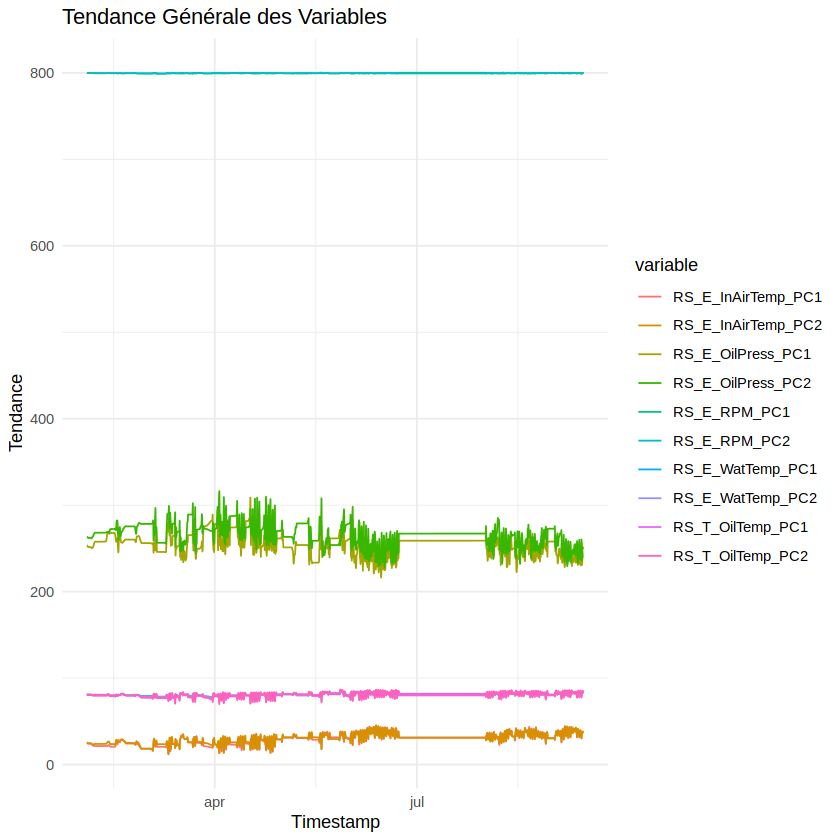

In [18]:
# Tracer la tendance générale pour chaque variable
ggplot(decomposed_data, aes(x = timestamps_UTC, y = trend, color = variable)) +
  geom_line() +
  labs(title = "Tendance Générale des Variables",
       x = "Timestamp",
       y = "Tendance") +
  theme_minimal()

In [20]:
# Extraire les données pour le véhicule spécifique
single_train_data <- data_df_WNA_tbl[data_df_WNA_tbl$mapped_veh_id == "190.0",]

single_train_data <- single_train_data %>%
  as_tbl_time(index = timestamps_UTC)

# Arrange data by timestamps
single_train_data <- single_train_data %>%
  arrange(timestamps_UTC)

# Extract trend component
trend_component <- single_train_data %>%
  time_decompose(RS_T_OilTemp_PC1, method = "stl") 


# Calculate the normal trend range
# Extract trend component values
trend_values <- trend_component$trend

library(ggplot2)
library(tsibble)

frequency = 25 minutes

trend = 173 minutes



Warning message in global_trend$trend - trend_values:
“longer object length is not a multiple of shorter object length”


NULL

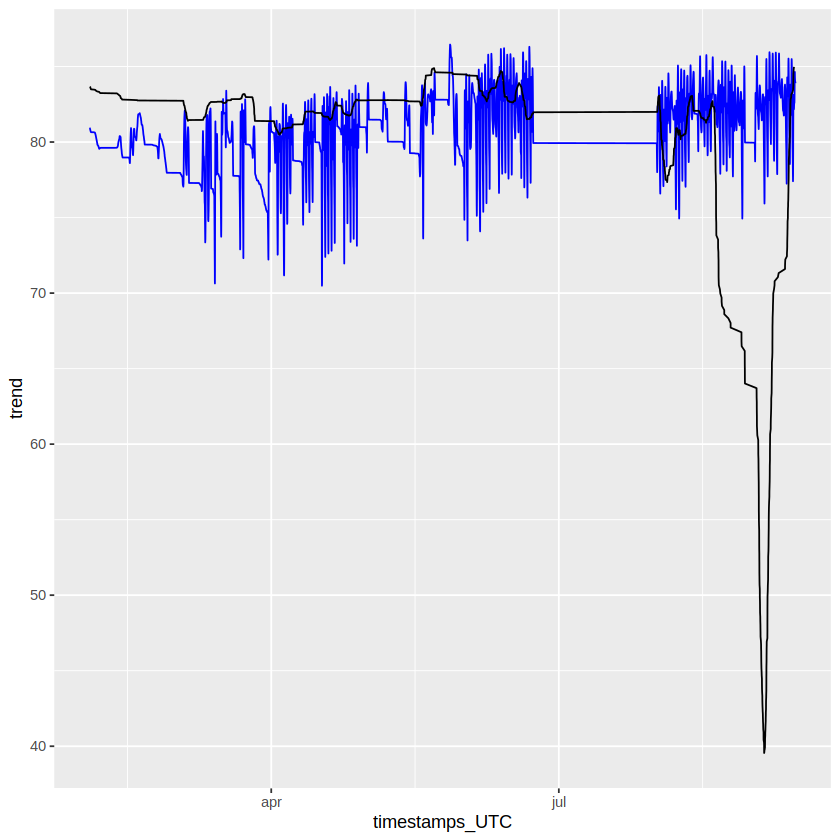

In [21]:
# Calculer la tendance globale
global_trend <- decomposed_data %>%
 filter(variable == "RS_T_OilTemp_PC1")

# Calculer la différence entre les deux tendances
difference <- global_trend$trend - trend_values

# Couleur du remplissage
fill_color <- ifelse(abs(difference) < 10, "green", "red")
# Tracer les tendances
ggplot() +
 geom_line(data = as.data.frame(global_trend), aes(x = timestamps_UTC, y = trend), color = "blue") +
 geom_line(data = as.data.frame(trend_component), aes(x = timestamps_UTC, y = trend), color = "black") 
 labs(title = "Tendance Générale et Individuelle",
  x = "Timestamp",
  y = "Tendance") +
 theme_minimal()


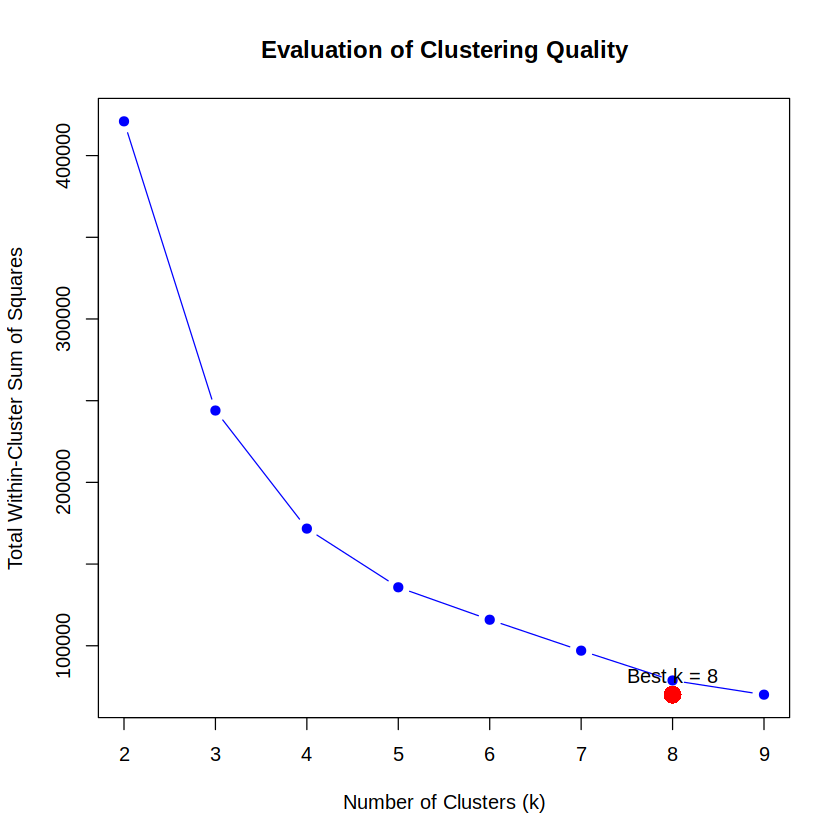

In [22]:
# Select relevant columns
selected_columns <- c("RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2")

# Subset the data
subset_data <- single_train_data[, selected_columns]

# Specify the range of k values to test
k_values <- 2:9

# Vector to store evaluation results
evaluation_results <- numeric(length(k_values))

# List to store k-means results
kmeans_results <- list()

# Loop through each k value
for (i in seq_along(k_values)) {
 k <- k_values[i]
  
 # Run k-means clustering
 kmeans_result <- kmeans(subset_data, centers = k, nstart = 20 )
  
 # Store the k-means result
 kmeans_results[[i]] <- kmeans_result
  
 # Store the total within-cluster sum of squares
 evaluation_results[i] <- kmeans_result$tot.withinss
}

# Plot the evaluation results
plot(k_values, evaluation_results, type = "b", pch = 19, col = "blue",
   xlab = "Number of Clusters (k)", ylab = "Total Within-Cluster Sum of Squares",
   main = "Evaluation of Clustering Quality")

# Add points for the best k (minimum within-cluster sum of squares)
best_k <- which.min(evaluation_results)
points(best_k, evaluation_results[best_k], col = "red", pch = 16, cex = 2)
text(best_k, evaluation_results[best_k], labels = paste("Best k =", best_k), pos = 3)

In [23]:
# Load the libraries
library(forecast)
library(keras)

In [26]:
# Install the lubridate package
install.packages("lubridate")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [27]:
library(lubridate)

In [40]:
# Install the necessary packages if not already installed
if (!requireNamespace("lubridate", quietly = TRUE)) {
  install.packages("lubridate")
}
if (!requireNamespace("padr", quietly = TRUE)) {
  install.packages("padr")
}

# Load the libraries
library(forecast)
library(keras)
library(lubridate)
library(padr)

cleaned_data_df <- data_df_WNA %>%
  distinct(timestamps_UTC, .keep_all = TRUE) %>%
  arrange(timestamps_UTC)

# Convert to tsibble
data_df_WNA_tsibble <- as_tsibble(data_df_WNA, index = timestamps_UTC)

# Resample the data to a 30-second interval
data_df_WNA_resampled <- data_df_WNA_tsibble %>%
  pad(interval = 30)
# Calculate the global trend
global_trend <- stl(data_df_WNA_resampled$RS_T_OilTemp_PC1, s.window = "periodic")$trend

# Split the data into training and testing sets
train_df <- data_df_WNA_resampled[1:800000,]
test_df <- data_df_WNA_resampled[800001:nrow(data_df_WNA_resampled),]

# Rescale the features
train_df_scaled <- scale(train_df)
test_df_scaled <- scale(test_df)

# Build the autoencoder
autoencoder <- keras_model_sequential()
autoencoder %>%
    layer_lstm(units = 128) %>%
    layer_dense(units = ncol(train_df_scaled))

# Compile the autoencoder
autoencoder %>% compile(optimizer = "adam", loss = "mse")

# Train the autoencoder
autoencoder %>% fit(train_df_scaled, train_df_scaled, epochs = 100)

# Evaluate the autoencoder
loss <- autoencoder %>% evaluate(test_df_scaled, test_df_scaled)

# Detect anomalies
reconstructed_test_df <- autoencoder %>% predict(test_df_scaled)
error_df <- data.frame(
    timestamp = test_df$timestamps_UTC,
    error = mean((reconstructed_test_df - test_df_scaled)^2)
)

anomalies <- error_df %>% filter(error > threshold)


ERROR: [1m[33mError[39m in `validate_tsibble()`:[22m
[33m![39m A valid tsibble must have distinct rows identified by key and index.
[34mℹ[39m Please use `duplicates()` to check the duplicated rows.
